In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.style.use('dark_background')

In [25]:
df = pd.read_csv('output_data/cleaned_interp.csv', parse_dates = ['datetime']).set_index('datetime')
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 420768 entries, 2013-03-01 00:00:00 to 2017-02-28 23:00:00
Data columns (total 17 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   PM2.5    420768 non-null  float64
 1   PM10     420768 non-null  float64
 2   SO2      420768 non-null  float64
 3   NO2      420768 non-null  float64
 4   CO       420768 non-null  float64
 5   O3       420768 non-null  float64
 6   TEMP     420768 non-null  float64
 7   PRES     420768 non-null  float64
 8   DEWP     420768 non-null  float64
 9   RAIN     420768 non-null  float64
 10  WSPM     420768 non-null  float64
 11  station  420768 non-null  object 
 12  wd       420768 non-null  object 
 13  year     420768 non-null  int64  
 14  month    420768 non-null  int64  
 15  day      420768 non-null  int64  
 16  hour     420768 non-null  int64  
dtypes: float64(11), int64(4), object(2)
memory usage: 57.8+ MB


In [26]:
df

,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM,station,wd,year,month,day,hour
datetime,,,,,,,,,,,,,,,,,
2013-03-01 00:00:00,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,4.4,Aotizhongxin,NNW,2013,3,1,0
2013-03-01 01:00:00,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,4.7,Aotizhongxin,N,2013,3,1,1
2013-03-01 02:00:00,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,5.6,Aotizhongxin,NNW,2013,3,1,2
2013-03-01 03:00:00,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,3.1,Aotizhongxin,NW,2013,3,1,3
2013-03-01 04:00:00,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,2.0,Aotizhongxin,N,2013,3,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-02-28 19:00:00,11.0,32.0,3.0,24.0,400.0,72.0,12.5,1013.5,-16.2,0.0,2.4,Wanshouxigong,NW,2017,2,28,19
2017-02-28 20:00:00,13.0,32.0,3.0,41.0,500.0,50.0,11.6,1013.6,-15.1,0.0,0.9,Wanshouxigong,WNW,2017,2,28,20
2017-02-28 21:00:00,14.0,28.0,4.0,38.0,500.0,54.0,10.8,1014.2,-13.3,0.0,1.1,Wanshouxigong,NW,2017,2,28,21


In [27]:
df[df.select_dtypes(include = 'float64').columns].describe()

,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM
count,420768.000000,420768.000000,420768.000000,420768.000000,420768.000000,420768.000000,420768.000000,420768.000000,420768.000000,420768.000000,420768.000000
mean,79.839718,104.910268,15.913090,50.600220,1235.682649,57.237872,13.531692,1010.753337,2.482421,0.064428,1.730034
std,80.950217,92.431422,21.896609,35.170876,1161.790893,57.135195,11.437867,10.474302,13.797675,0.820638,1.246674
min,2.000000,2.000000,0.285600,1.026500,100.000000,0.214200,-19.900000,982.400000,-43.400000,0.000000,0.000000
25%,20.000000,36.000000,3.000000,23.000000,500.000000,10.000000,3.100000,1002.300000,-8.900000,0.000000,0.900000
50%,55.000000,82.000000,7.000000,43.000000,900.000000,44.000000,14.500000,1010.400000,3.000000,0.000000,1.400000
75%,111.000000,145.000000,20.000000,71.000000,1500.000000,82.000000,23.300000,1019.000000,15.100000,0.000000,2.200000
max,999.000000,999.000000,500.000000,290.000000,10000.000000,1071.000000,41.600000,1042.800000,29.100000,72.500000,13.200000


In [29]:
data = df.drop(['wd', 'station'], axis = 1).groupby(df.index).mean()
data.describe()

,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM,year,month,day,hour
count,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000
mean,79.839718,104.910268,15.913090,50.600220,1235.682649,57.237872,13.531692,1010.753337,2.482421,0.064428,1.730034,2014.662560,6.522930,15.729637,11.500000
std,76.057009,84.640437,19.671423,29.135133,1043.520821,53.390879,11.398645,10.211632,13.728769,0.602865,1.047901,1.177213,3.448752,8.800218,6.922285
min,3.250000,4.083333,1.202333,4.003150,125.000000,1.250000,-16.625000,985.408333,-34.866667,0.000000,0.066667,2013.000000,1.000000,1.000000,0.000000
25%,23.081250,41.151389,3.594821,28.083333,566.666667,15.583333,3.133333,1002.241667,-8.941667,0.000000,1.000000,2014.000000,4.000000,8.000000,5.750000
50%,57.916667,86.416667,8.083333,45.500000,916.666667,43.916667,14.508333,1010.525000,2.966667,0.000000,1.425000,2015.000000,7.000000,16.000000,11.500000
75%,109.000000,141.500000,20.000000,67.250000,1524.875000,78.944444,23.241667,1019.083333,15.158333,0.000000,2.158333,2016.000000,10.000000,23.000000,17.250000
max,692.000000,779.416667,248.666667,192.916667,8960.582011,334.647163,40.425000,1040.158333,27.900000,25.008333,8.666667,2017.000000,12.000000,31.000000,23.000000


In [30]:
def monthly_mean_pollutant_conc(df = df, pollutants = ['PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3']):
    stations = df['station'].unique()
    num_stations = len(stations)

    monthly_avg = df.drop(['wd'], axis = 1).groupby('station').resample('ME').mean().reset_index()

    fig, axes = plt.subplots(nrows = num_stations//3, ncols = 3, sharex = True, figsize = (18, num_stations))
    axes = axes.ravel()

    for ax, station in zip(axes, stations):
        station_data = monthly_avg[monthly_avg['station'] == station]

        for pollutant in pollutants:
            ax.plot(station_data['datetime'], station_data[pollutant], label = pollutant)
        ax.set_title(f'{station}')
        ax.set_ylabel(r'Concentration ($\mu g/m^3$)')
        ax.legend()
        

    fig.autofmt_xdate()
    plt.show()    

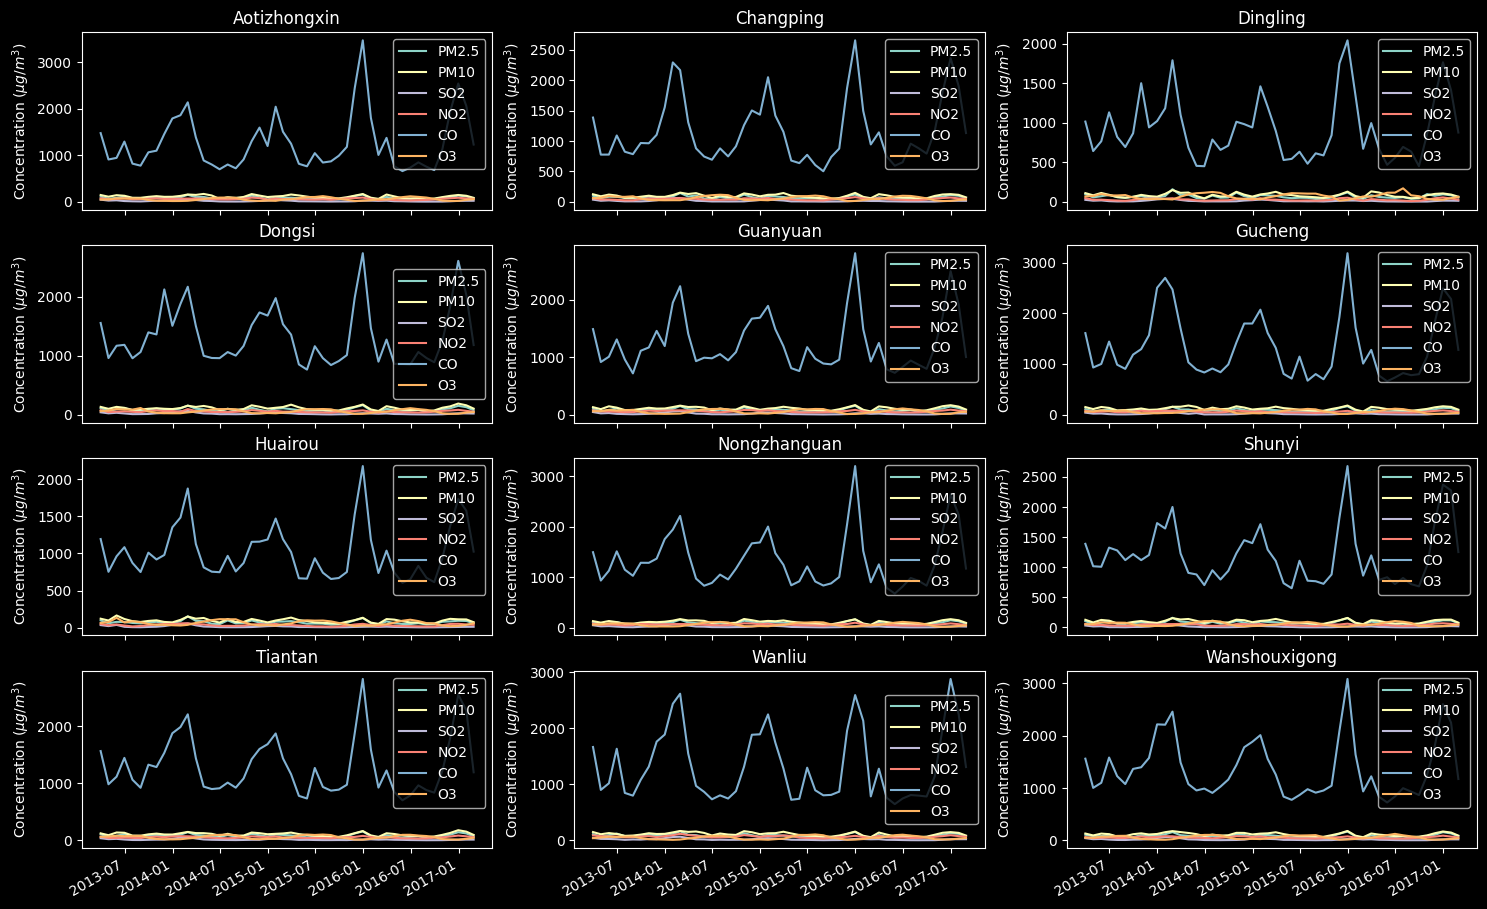

In [31]:
monthly_mean_pollutant_conc()

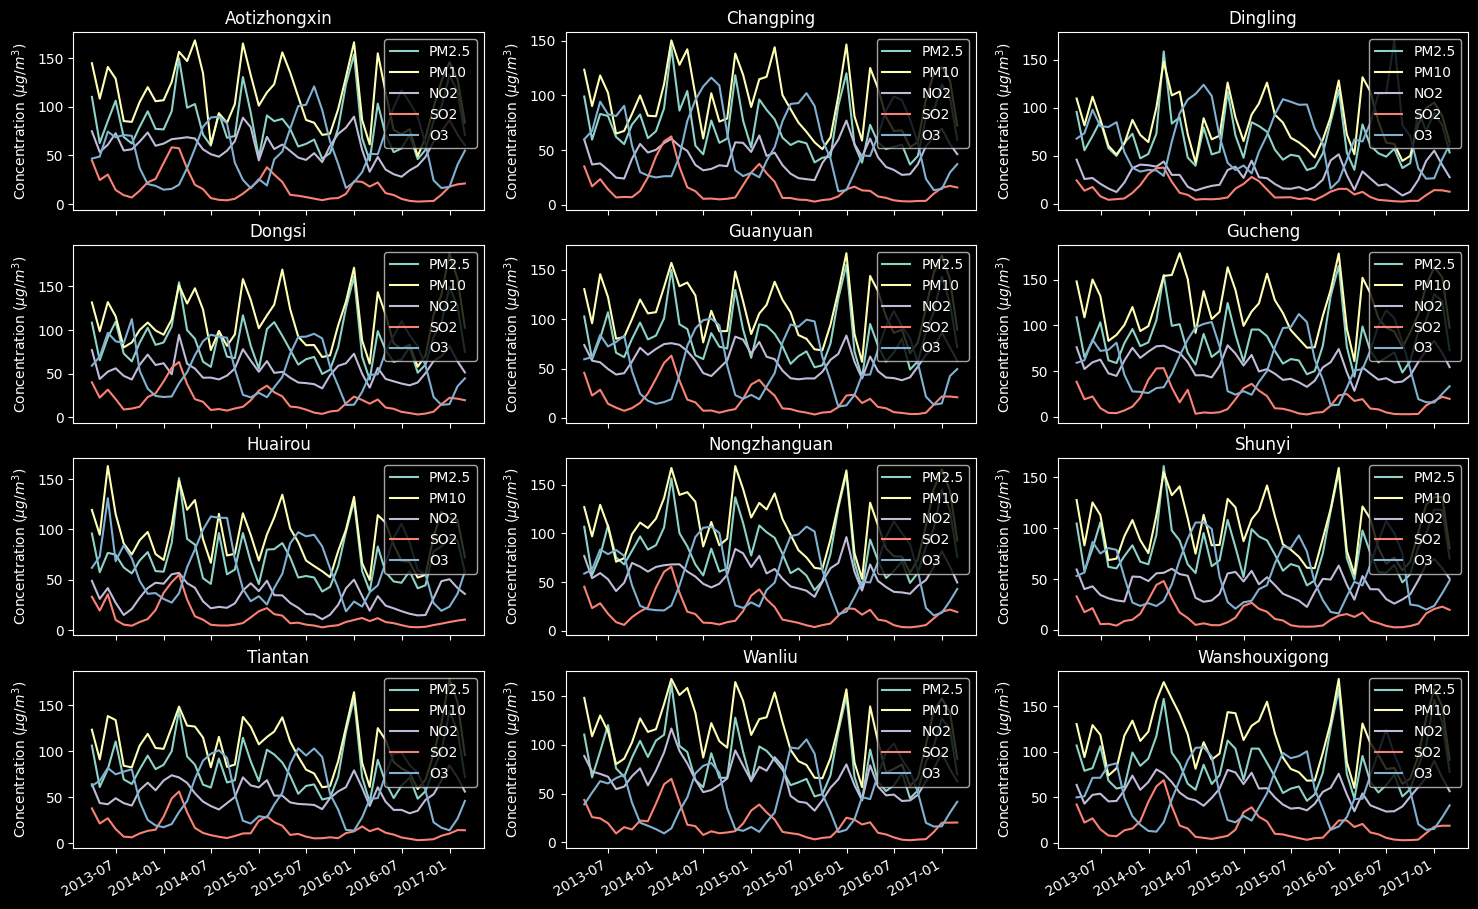

In [32]:
monthly_mean_pollutant_conc(pollutants = ['PM2.5', 'PM10', 'NO2', 'SO2', 'O3'])

<Axes: >

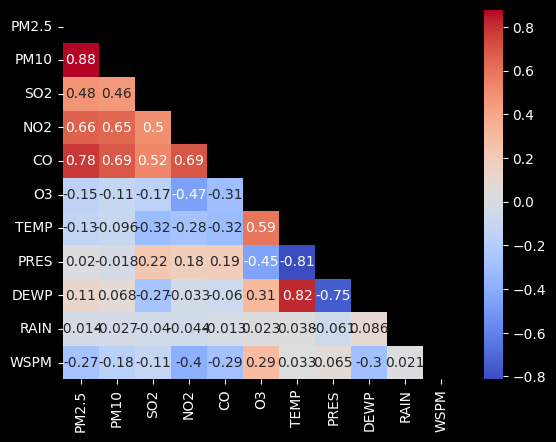

In [33]:
corr_matrix = df[df.select_dtypes(include = 'float64').columns].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype = bool))
sns.heatmap(corr_matrix, mask = mask, annot = True, cmap = 'coolwarm')

In [34]:
def correlation_scatter(df, var1, var2):   
    stations = df['station'].unique()
    num_stations = len(stations)

    monthly_avg = df.drop('wd', axis = 1).groupby('station').resample('ME').mean().reset_index()
    
    fig, axes = plt.subplots(nrows = num_stations//3, ncols = 3, sharex = True, figsize = (18, num_stations))
    axes = axes.ravel()

    for ax, station in zip(axes, stations):
        station_data = monthly_avg[monthly_avg['station'] == station]

        ax.scatter(station_data[var1], station_data[var2])
        ax.set_title(f"{station}")
        
    fig.suptitle(f'{var1} vs. {var2}', fontsize = 14)
    fig.supxlabel(f'{var1}', fontsize = 12)
    plt.show()

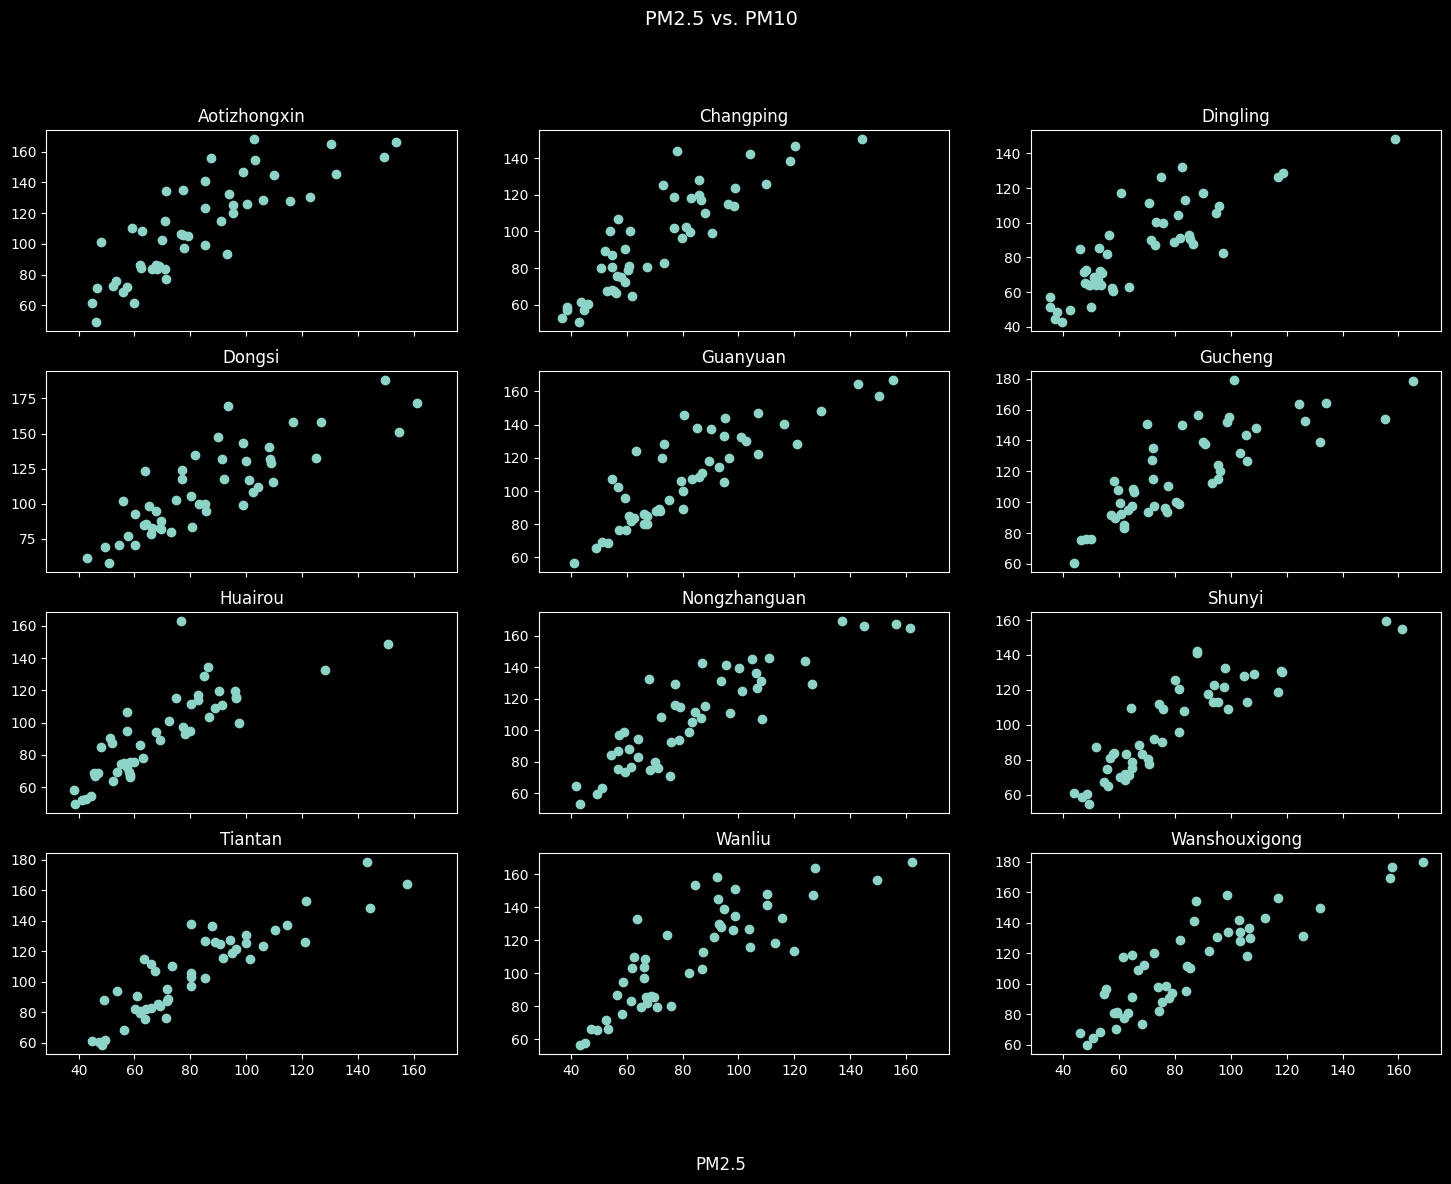

In [35]:
correlation_scatter(df, 'PM2.5', 'PM10')

In [38]:
def seasonality_plots(pollutant, df = df):
    
    data = df.drop(['wd', 'station'], axis = 1).groupby(df.index).mean()
    fig, ax = plt.subplots(2, 2, figsize = (12, 8), sharex = False, sharey = True)
    axes = ax.ravel()

    #monthly
    data.boxplot(column = pollutant, by = 'month', ax = axes[0])
    data.groupby('month')[pollutant].median().plot(style = 'o-', linewidth = 0.8, ax = axes[0])
    axes[0].set_ylabel(pollutant)
    axes[0].set_title(fr'{pollutant} levels by month ($\mu g/m^3$)')

    #week day
    data['week_day'] = data.index.day_of_week + 1
    data.boxplot(column = pollutant, by = 'week_day', ax = axes[1])
    data.groupby('week_day')[pollutant].median().plot(style = 'o-', linewidth = 0.8, ax = axes[1])
    axes[1].set_ylabel(pollutant)
    axes[1].set_title(fr'{pollutant} levels by week day ($\mu g/m^3$)')

    #hourly
    data.boxplot(column = pollutant, by = 'hour', ax = axes[2])
    data.groupby('hour')[pollutant].median().plot(style = 'o-', linewidth = 0.8, ax = axes[2])
    axes[2].set_ylabel(pollutant)
    axes[2].set_title(fr'{pollutant} levels by hour ($\mu g/m^3$)')
    axes[2].set_xticklabels(i + 1 for i in range(24))

    #during the week
    mean_week = data.groupby(['week_day', 'hour'])[pollutant].mean()
    mean_week.plot(ax = axes[3])
    axes[3].set(
        title = fr'Mean {pollutant} levels over week ($\mu g/m^3$)',
        xticks = [i * 24 for i in range(7)],
        xticklabels = ['Mon', 'Tues', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'],
        xlabel = 'Day and hour of week'
    )

    fig.suptitle('Seasonality Plots', fontsize = 12)
    plt.tight_layout()

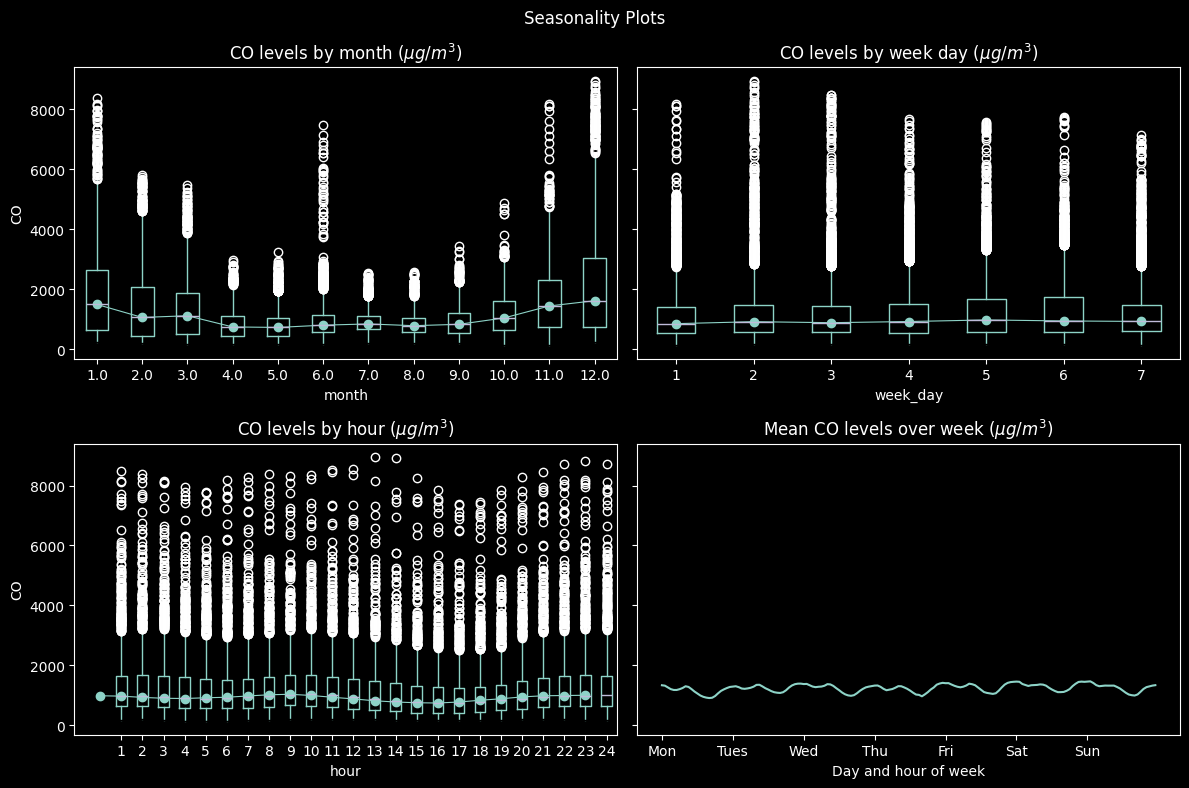

In [39]:
seasonality_plots('CO')

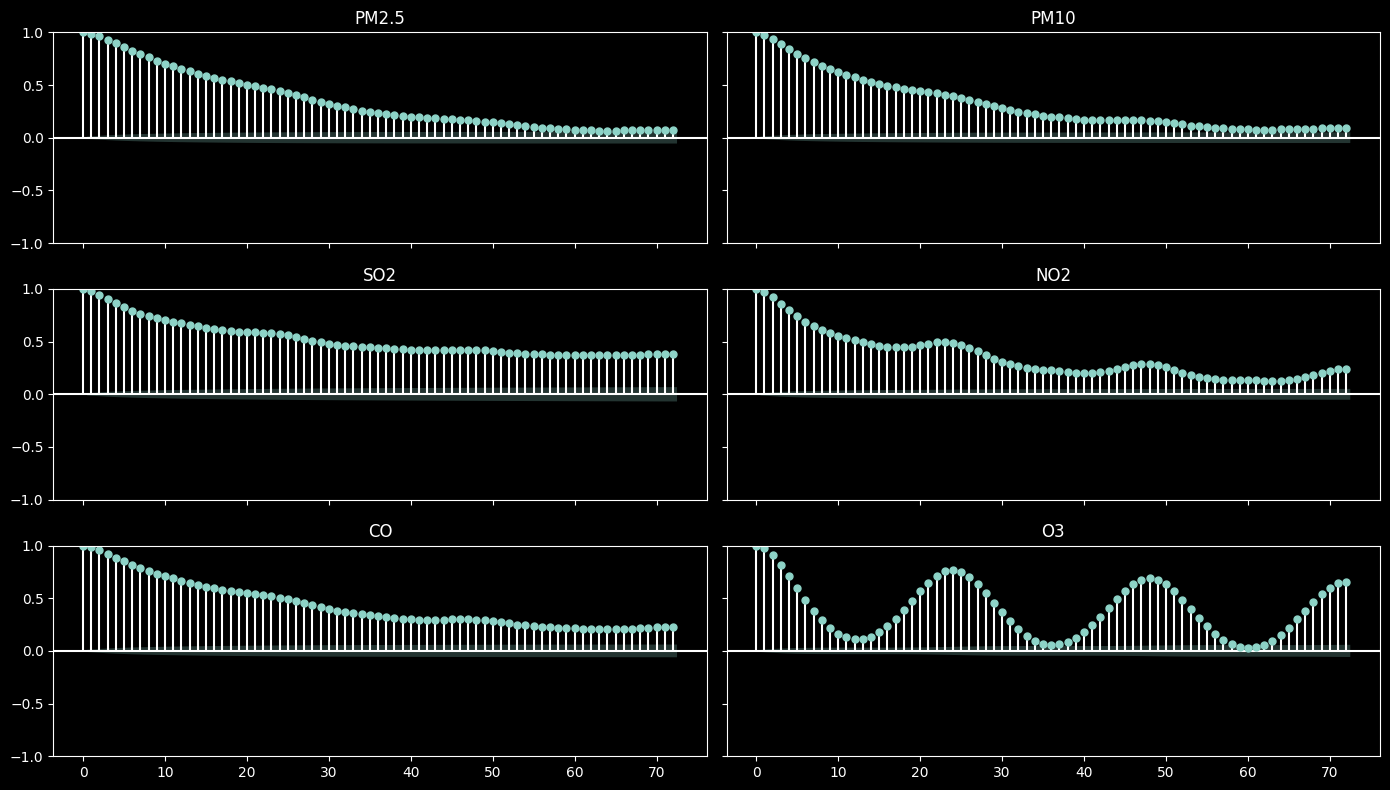

In [40]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

def acf_plot(method = 'ACF'):

    data = df.drop(['wd', 'station'], axis = 1).groupby(df.index).mean()
    fig, ax = plt.subplots(3, 2, figsize = (14, 8), sharex = True, sharey = True)
    axes = ax.ravel()

    pollutants = ['PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3']

    for ax, pollutant in zip(axes, pollutants):
        if method == 'ACF':
            plot_acf(data[pollutant], ax = ax, lags = 72)
        elif method == 'PACF':
            plot_pacf(data[pollutant], ax = ax, lags = 72)
        ax.set_title(f'{pollutant}')


    plt.tight_layout()

acf_plot()

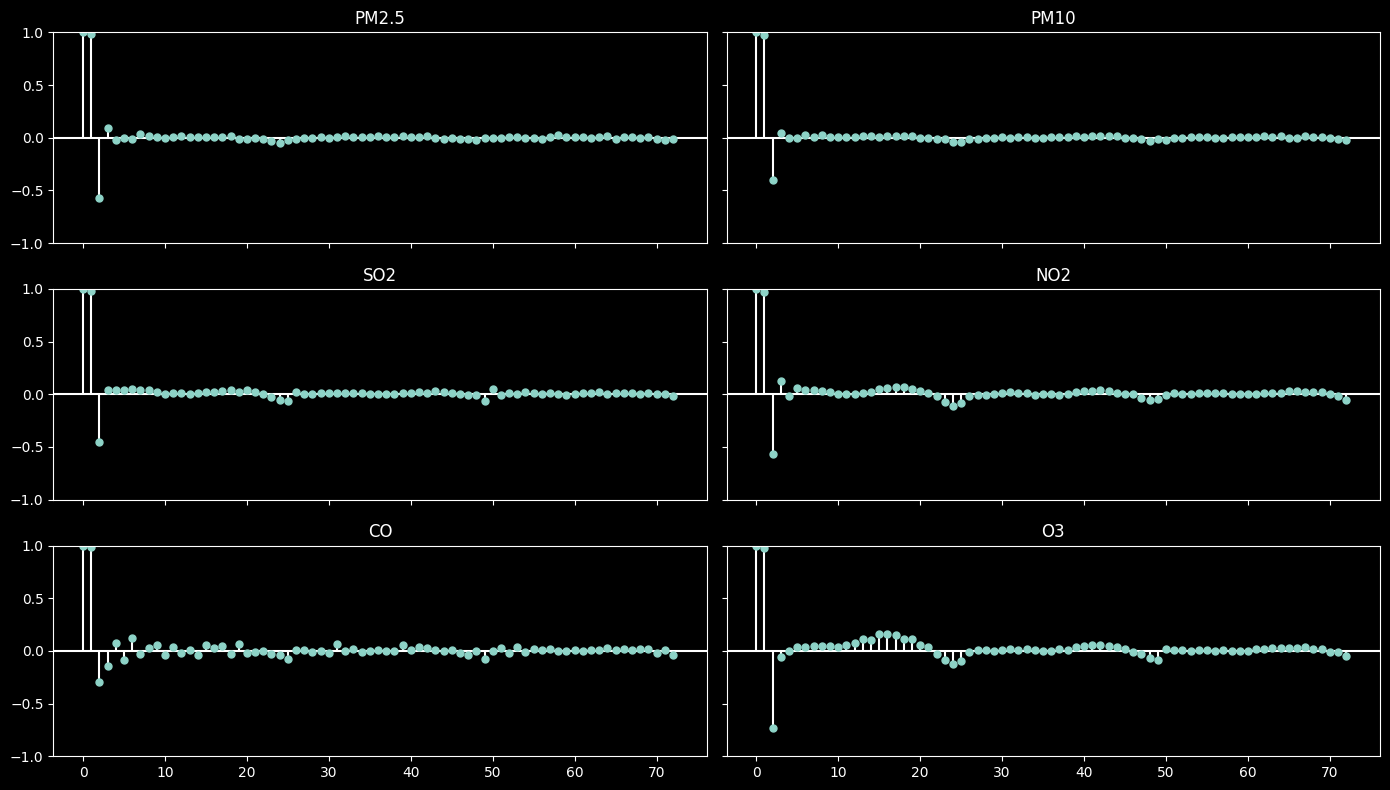

In [ ]:
acf_plot(method = 'PACF')